In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [4]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# 1. Make Data X_train, y_train, X_test, y_test

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [6]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

inp = open(file_path+'detect_peptide_train_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

In [7]:
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 30) (84295, 30) (88998, 30) (337179,) (84295,) (88998,)


# 2. train

In [8]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           19328     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [9]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 59s 176us/sample - loss: 0.6143 - acc: 0.7449 - val_loss: 0.5950 - val_acc: 0.7942
Epoch 2/200
337179/337179 [==============================] - 57s 170us/sample - loss: 0.5946 - acc: 0.8006 - val_loss: 0.5928 - val_acc: 0.8004
Epoch 3/200
337179/337179 [==============================] - 58s 171us/sample - loss: 0.5933 - acc: 0.8040 - val_loss: 0.5936 - val_acc: 0.7925
Epoch 4/200
337179/337179 [==============================] - 57s 170us/sample - loss: 0.5924 - acc: 0.8054 - val_loss: 0.5910 - val_acc: 0.8069
Epoch 5/200
337179/337179 [==============================] - 57s 170us/sample - loss: 0.5919 - acc: 0.8064 - val_loss: 0.5906 - val_acc: 0.8052
Epoch 6/200
337179/337179 [==============================] - 58s 172us/sample - loss: 0.5915 - acc: 0.8076 - val_loss: 0.5904 - val_acc: 0.8047
Epoch 7/200
337179/337179 [==============================] - 58s 171us/sample - loss:

337179/337179 [==============================] - 60s 177us/sample - loss: 0.5756 - acc: 0.8411 - val_loss: 0.5756 - val_acc: 0.8386
Epoch 58/200
337179/337179 [==============================] - 59s 175us/sample - loss: 0.5755 - acc: 0.8410 - val_loss: 0.5758 - val_acc: 0.8369
Epoch 59/200
337179/337179 [==============================] - 59s 176us/sample - loss: 0.5752 - acc: 0.8415 - val_loss: 0.5759 - val_acc: 0.8441
Epoch 60/200
337179/337179 [==============================] - 59s 176us/sample - loss: 0.5750 - acc: 0.8421 - val_loss: 0.5753 - val_acc: 0.8420
Epoch 61/200
337179/337179 [==============================] - 59s 176us/sample - loss: 0.5753 - acc: 0.8408 - val_loss: 0.5751 - val_acc: 0.8409
Epoch 62/200
337179/337179 [==============================] - 59s 176us/sample - loss: 0.5751 - acc: 0.8421 - val_loss: 0.5760 - val_acc: 0.8375
Epoch 63/200
337179/337179 [==============================] - 59s 175us/sample - loss: 0.5751 - acc: 0.8417 - val_loss: 0.5758 - val_acc: 0.845

337179/337179 [==============================] - 63s 185us/sample - loss: 0.5730 - acc: 0.8471 - val_loss: 0.5753 - val_acc: 0.8380
Epoch 114/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5726 - acc: 0.8478 - val_loss: 0.5756 - val_acc: 0.8339
Epoch 115/200
337179/337179 [==============================] - 63s 186us/sample - loss: 0.5729 - acc: 0.8472 - val_loss: 0.5747 - val_acc: 0.8435
Epoch 116/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5728 - acc: 0.8477 - val_loss: 0.5745 - val_acc: 0.8411
Epoch 117/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5728 - acc: 0.8481 - val_loss: 0.5743 - val_acc: 0.8415
Epoch 118/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5726 - acc: 0.8480 - val_loss: 0.5747 - val_acc: 0.8368
Epoch 119/200
337179/337179 [==============================] - 63s 186us/sample - loss: 0.5726 - acc: 0.8478 - val_loss: 0.5750 - val_acc:

337179/337179 [==============================] - 63s 186us/sample - loss: 0.5715 - acc: 0.8506 - val_loss: 0.5742 - val_acc: 0.8397
Epoch 170/200
337179/337179 [==============================] - 63s 186us/sample - loss: 0.5714 - acc: 0.8511 - val_loss: 0.5745 - val_acc: 0.8399
Epoch 171/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5714 - acc: 0.8509 - val_loss: 0.5742 - val_acc: 0.8403
Epoch 172/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5714 - acc: 0.8512 - val_loss: 0.5743 - val_acc: 0.8433
Epoch 173/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5712 - acc: 0.8517 - val_loss: 0.5747 - val_acc: 0.8381
Epoch 174/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5715 - acc: 0.8508 - val_loss: 0.5755 - val_acc: 0.8386
Epoch 175/200
337179/337179 [==============================] - 62s 185us/sample - loss: 0.5711 - acc: 0.8521 - val_loss: 0.5748 - val_acc:

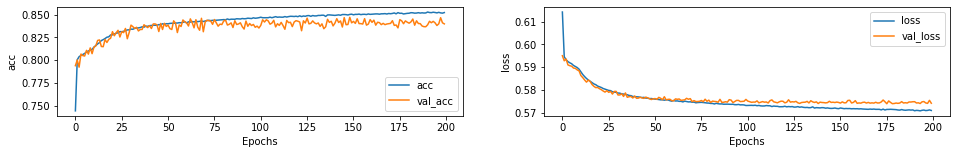

In [10]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 2-2. Github code

Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 81) (84295, 81) (88998, 81) (337179,) (84295,) (88998,)
Loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 45s 135us/sample - loss: 0.4376 - acc: 0.7901 - binary_crossentropy: 0.4376 - val_loss: 0.3785 - val_acc: 0.8252 - val_binary_crossentropy: 0.3785
Epoch 2/200
337179/337179 [==============================] - 44s 131us/sample - loss: 0.3803 - acc: 0.8274 - binary_crossentropy: 0.3803 - val_loss: 0.3651 - val_acc: 0.8322 - val_binary_crossentropy: 0.3651
Epoch 3/200
337179/337179 [==============================] - 44s 131us/s

Epoch 35/200
337179/337179 [==============================] - 70s 207us/sample - loss: 0.3296 - acc: 0.8549 - binary_crossentropy: 0.3296 - val_loss: 0.3396 - val_acc: 0.8493 - val_binary_crossentropy: 0.3396
Epoch 36/200
337179/337179 [==============================] - 69s 205us/sample - loss: 0.3294 - acc: 0.8556 - binary_crossentropy: 0.3294 - val_loss: 0.3368 - val_acc: 0.8503 - val_binary_crossentropy: 0.3368
Epoch 37/200
337179/337179 [==============================] - 69s 204us/sample - loss: 0.3287 - acc: 0.8554 - binary_crossentropy: 0.3287 - val_loss: 0.3343 - val_acc: 0.8504 - val_binary_crossentropy: 0.3343
Epoch 38/200
337179/337179 [==============================] - 70s 206us/sample - loss: 0.3286 - acc: 0.8549 - binary_crossentropy: 0.3286 - val_loss: 0.3360 - val_acc: 0.8524 - val_binary_crossentropy: 0.3360
Epoch 39/200
337179/337179 [==============================] - 70s 207us/sample - loss: 0.3279 - acc: 0.8556 - binary_crossentropy: 0.3279 - val_loss: 0.3345 - val_a

337179/337179 [==============================] - 69s 205us/sample - loss: 0.3194 - acc: 0.8595 - binary_crossentropy: 0.3194 - val_loss: 0.3316 - val_acc: 0.8542 - val_binary_crossentropy: 0.3316
Epoch 75/200
337179/337179 [==============================] - 69s 204us/sample - loss: 0.3188 - acc: 0.8600 - binary_crossentropy: 0.3188 - val_loss: 0.3337 - val_acc: 0.8521 - val_binary_crossentropy: 0.3337
Epoch 76/200
337179/337179 [==============================] - 69s 204us/sample - loss: 0.3181 - acc: 0.8597 - binary_crossentropy: 0.3181 - val_loss: 0.3356 - val_acc: 0.8529 - val_binary_crossentropy: 0.3356
Epoch 77/200
337179/337179 [==============================] - 69s 204us/sample - loss: 0.3184 - acc: 0.8598 - binary_crossentropy: 0.3184 - val_loss: 0.3310 - val_acc: 0.8525 - val_binary_crossentropy: 0.3310
Epoch 78/200
337179/337179 [==============================] - 68s 201us/sample - loss: 0.3179 - acc: 0.8607 - binary_crossentropy: 0.3179 - val_loss: 0.3328 - val_acc: 0.8522 - 

337179/337179 [==============================] - 60s 178us/sample - loss: 0.3141 - acc: 0.8624 - binary_crossentropy: 0.3141 - val_loss: 0.3325 - val_acc: 0.8539 - val_binary_crossentropy: 0.3325
Epoch 114/200
337179/337179 [==============================] - 61s 182us/sample - loss: 0.3140 - acc: 0.8628 - binary_crossentropy: 0.3140 - val_loss: 0.3318 - val_acc: 0.8540 - val_binary_crossentropy: 0.3318
Epoch 115/200
337179/337179 [==============================] - 58s 171us/sample - loss: 0.3144 - acc: 0.8621 - binary_crossentropy: 0.3144 - val_loss: 0.3335 - val_acc: 0.8533 - val_binary_crossentropy: 0.3335
Epoch 116/200
337179/337179 [==============================] - 61s 180us/sample - loss: 0.3146 - acc: 0.8618 - binary_crossentropy: 0.3146 - val_loss: 0.3371 - val_acc: 0.8535 - val_binary_crossentropy: 0.3371
Epoch 117/200
337179/337179 [==============================] - 60s 177us/sample - loss: 0.3138 - acc: 0.8622 - binary_crossentropy: 0.3138 - val_loss: 0.3319 - val_acc: 0.853

337179/337179 [==============================] - 58s 173us/sample - loss: 0.3118 - acc: 0.8635 - binary_crossentropy: 0.3118 - val_loss: 0.3331 - val_acc: 0.8535 - val_binary_crossentropy: 0.3331
Epoch 153/200
337179/337179 [==============================] - 60s 179us/sample - loss: 0.3108 - acc: 0.8645 - binary_crossentropy: 0.3108 - val_loss: 0.3334 - val_acc: 0.8521 - val_binary_crossentropy: 0.3334
Epoch 154/200
337179/337179 [==============================] - 60s 179us/sample - loss: 0.3113 - acc: 0.8639 - binary_crossentropy: 0.3113 - val_loss: 0.3352 - val_acc: 0.8523 - val_binary_crossentropy: 0.3352
Epoch 155/200
337179/337179 [==============================] - 60s 179us/sample - loss: 0.3109 - acc: 0.8638 - binary_crossentropy: 0.3109 - val_loss: 0.3368 - val_acc: 0.8510 - val_binary_crossentropy: 0.3368
Epoch 156/200
337179/337179 [==============================] - 59s 174us/sample - loss: 0.3108 - acc: 0.8644 - binary_crossentropy: 0.3108 - val_loss: 0.3392 - val_acc: 0.849

337179/337179 [==============================] - 51s 152us/sample - loss: 0.3095 - acc: 0.8646 - binary_crossentropy: 0.3095 - val_loss: 0.3347 - val_acc: 0.8524 - val_binary_crossentropy: 0.3347
Epoch 192/200
337179/337179 [==============================] - 47s 138us/sample - loss: 0.3087 - acc: 0.8652 - binary_crossentropy: 0.3087 - val_loss: 0.3348 - val_acc: 0.8521 - val_binary_crossentropy: 0.3348
Epoch 193/200
337179/337179 [==============================] - 47s 139us/sample - loss: 0.3085 - acc: 0.8659 - binary_crossentropy: 0.3085 - val_loss: 0.3361 - val_acc: 0.8529 - val_binary_crossentropy: 0.3361
Epoch 194/200
337179/337179 [==============================] - 49s 145us/sample - loss: 0.3089 - acc: 0.8653 - binary_crossentropy: 0.3089 - val_loss: 0.3344 - val_acc: 0.8535 - val_binary_crossentropy: 0.3344
Epoch 195/200
337179/337179 [==============================] - 48s 143us/sample - loss: 0.3091 - acc: 0.8650 - binary_crossentropy: 0.3091 - val_loss: 0.3377 - val_acc: 0.849

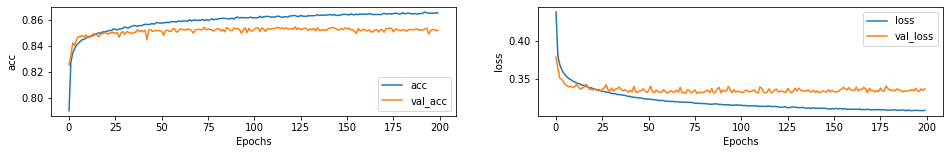

In [11]:
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train81, X_val81, y_train81, y_val81 = train_test_split(X_train81, y_train81, test_size=0.2)
print(X_train81.shape, X_val81.shape, X_test81.shape, y_train81.shape, y_val81.shape, y_test81.shape)


print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')

history_github = model_2_1D.fit(X_train81, y_train81, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val81, y_val81))

plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_github, 'acc')
plt.subplot(1,2,2)
plot_graphs(history_github, 'loss')

# 3. test

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

88998/88998 [==============================] - 6s 64us/sample - loss: 0.5695 - acc: 0.8633
Test Loss: 0.569490050697046
Test Accuracy: 0.8632665872573853
              precision    recall  f1-score   support

           0       0.85      0.88      0.87     44509
           1       0.87      0.85      0.86     44489

    accuracy                           0.86     88998
   macro avg       0.86      0.86      0.86     88998
weighted avg       0.86      0.86      0.86     88998

rf auc : 0.9195619404364757


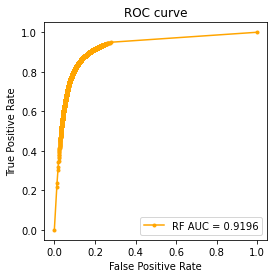

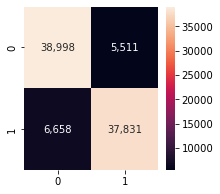

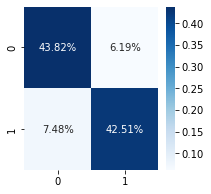

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

88998/88998 [==============================] - 7s 77us/sample - loss: 0.3391 - acc: 0.8542 - binary_crossentropy: 0.3391
Test Loss: 0.569490050697046
Test Accuracy: [0.33912464481447113, 0.8541877, 0.33912423]
              precision    recall  f1-score   support

           0       0.91      0.79      0.84     44509
           1       0.81      0.92      0.86     44489

    accuracy                           0.85     88998
   macro avg       0.86      0.85      0.85     88998
weighted avg       0.86      0.85      0.85     88998

rf auc : 0.9339800137281874


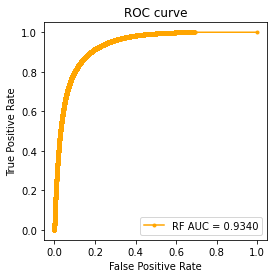

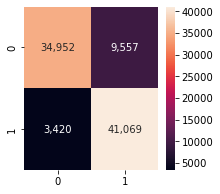

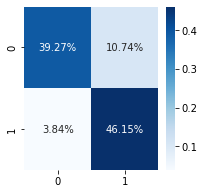

In [14]:
test_acc = model_2_1D.evaluate(X_test81, y_test81)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test81)]
print(classification_report(y_test81, y_pred))
# AUC
probs = model_2_1D.predict(X_test81)
rf_auc = roc_auc_score(y_test81, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test81, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test81, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# check zero MSGF peptides property

In [15]:
import pickle

with open('pep_zeroMSGF_noptm.pickle', 'rb') as f:
    pep_zeroMSGF_noptm = pickle.load(f)

In [16]:
max_len=81

aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in pep_zeroMSGF_noptm:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

In [17]:
predict_label = np.array([0]*len(predict_data))

In [18]:
test_acc = model_2_1D.evaluate(predict_data, predict_label)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(predict_data)]
print(classification_report(predict_label, y_pred))

93542/93542 [==============================] - 7s 77us/sample - loss: 1.0802 - acc: 0.6148 - binary_crossentropy: 1.0802
Test Loss: 0.569490050697046
Test Accuracy: [1.0802476228004148, 0.6147613, 1.0802478]
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     93542
           1       0.00      0.00      0.00         0

    accuracy                           0.61     93542
   macro avg       0.50      0.31      0.38     93542
weighted avg       1.00      0.61      0.76     93542



/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_prob = model_2_1D.predict(predict_data)

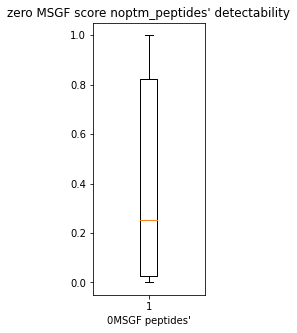

In [20]:
plt.figure(figsize=(2,5))
plt.boxplot(y_prob.reshape(-1))
plt.title('zero MSGF score noptm_peptides\' detectability')
plt.xlabel('0MSGF peptides\'')
plt.show()